# osu! Beatmaps Failtimes Prediction
**Contributors:** Sophie Yun, Emily Gong, Sine Polcharoen

# Introduction

**Our Problem:** 


**Our Data:** In the original data source, each **Beatmap** is divided into 100 time intervals and **Failtimes** indicates the number of players failed at each interval. We assume that the **Failtimes** and the **Hit Objects** are closely correlated, so we extracted all the information about those two attributes, which include x, y, x1, y1, repeat_count, duration, d_time, and time. 

EXAMPLE: slider, spinning note
All times are in milliseconds.

# Data Processing

In [1]:
import sys
sys.path.append('../..')
import pandas as pd
from pymongo import UpdateOne
import numpy as np
from config import client
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
import scipy.stats as stats
from preliminary_modeling_failtimes import Xgboost_est_pp_model

from failtimes_functions import CREATE_ARRAY_FOR_MODEL, CREATE_COORDINATES_DIST_ARRAY_FOR_MODEL, CREATE_EASY_DF, CREATE_PARTITION_DF

## Introduction and Data Retrieval

In [2]:
db = client["osu_mlpp_db1"]
new_beatmaps = list(db.osu_beatmaps.find({"difficultyrating" : {"$gte": 1.5, "$lt": 2}}, 
                                         {"_id" : 1, "mlpp.hit_objects": 1, "mlpp.fail" : 1, 
                                          "difficultyrating" : 1, "playcount": 1, 
                                          "total_length": 1}).limit(500))

## Data Processing

### 1. By Time Intervals

In [3]:
#remove hit_objects = none
for bm in new_beatmaps:
    if bm["mlpp"]["hit_objects"] == None:
        new_beatmaps.remove(bm)
    if bm["mlpp"]["fail"] == None:
        new_beatmaps.remove(bm)

In [4]:
# check the dataframe for hit objects for one of the easiest beatmaps
hit_objects_colnames = ["x","y","x1","y1","repeat_count","duration", "d_time","time"]

new_df = pd.DataFrame(new_beatmaps[0]["mlpp"]["hit_objects"], 
                  columns = hit_objects_colnames)
new_df

,x,y,x1,y1,repeat_count,duration,d_time,time
0,64,320,64,320,1,0,5538,5538
1,64,192,64,192,1,0,697,6235
2,64,64,64,64,1,0,698,6933
3,448,64,448,64,1,0,1395,8328
4,448,192,448,192,1,0,698,9026
...,...,...,...,...,...,...,...,...
78,256,32,256,312,3,697,697,76700
79,64,64,64,64,1,0,2094,79491
80,160,64,440,258,1,1046,698,80189
81,448,160,448,160,1,0,349,81584


#### Create a dataframe for all beatmaps 
* Each row represents one hundredth of the beatmap in time
* failtimes_norm: failtimes / play counts
* coord_dist_sum: distance between (x1, y1) and (x, y)
    * sum of coord_dist of all hit objects in each time interval
    * used help function CREATE_COORDINATES_DIST_ARRAY_FOR_MODEL
* repeat_count_sum: number of movements for a hit object (i.e., a hit circle gets 0, a slider that moves from one location to another gets 1)
    * sum of repeat_count of all hit objects in each time interval
    * used help function CREATE_ARRAY_FOR_MODEL
* duration_sum: time to complete a hit (i.e., a hit circle gets 0, a slider gets some greater positive number)
    * sum of duration of all hit objects in each time interval
    * used help function CREATE_ARRAY_FOR_MODEL
* d_time_avg: time from the previous object to the current object
    * average of d_time of all hit objects in each time interval
    * used help function CREATE_ARRAY_FOR_MODEL

In [5]:
easy_df = CREATE_EASY_DF(new_beatmaps, hit_objects_colnames)
easy_df

,time,failtimes,failtimes_norm,coord_dist_sum,repeat_count_sum,duration_sum,d_time_avg
0,822.82,0,0.000000,0.0,0,0,0.000000
1,1645.64,0,0.000000,0.0,0,0,0.000000
2,2468.46,0,0.000000,0.0,0,0,0.000000
3,3291.28,0,0.000000,0.0,0,0,0.000000
4,4114.10,0,0.000000,0.0,0,0,0.000000
...,...,...,...,...,...,...,...
49995,76861.44,127,0.001172,0.0,0,0,0.000000
49996,77662.08,62,0.000572,0.0,0,0,0.000000
49997,78462.72,125,0.001154,0.0,3,0,322.666667
49998,79263.36,123,0.001135,0.0,3,0,242.000000


### 2. By Hit Objects

#### Create a dataframe for all beatmaps 
* Each row represents one chunk with at least 2 hit objects
    * i.e., First chunk merges the first 8 intervals and contains 2 hit objects. Second chunk takes the next 3 intervals and contains 3 hit objects, etc.
* All column names are similar to what are in easy_df except that we sum over all objects (average for d_time) within each chunk


In [6]:
min_size = 2
partition_all_df = CREATE_PARTITION_DF(new_beatmaps, easy_df, min_size)
partition_all_df

,num_hit_objects,chunks,failtimes_norm_sum,coord_dist_sum_sum,repeat_count_sum_sum,duration_sum_sum,d_time_avg_avg
0,2,8,0.000000,0.000000,2,0,779.375000
1,3,3,0.000000,0.000000,3,0,581.500000
2,2,3,0.000000,0.000000,2,0,697.666667
3,3,2,0.000038,0.000000,2,0,697.500000
4,2,2,0.000171,0.000000,3,0,697.500000
...,...,...,...,...,...,...,...
31,3,2,0.002323,0.000000,3,0,697.500000
32,3,3,0.002818,243.706791,3,697,698.000000
33,3,5,0.003914,0.000000,4,0,436.000000
34,4,1,0.004885,280.000000,4,697,261.500000


## Model Fitting

### 1. Linear Regression Model

Coefficients for linear regression are [-1.31000474e-08 -3.37017458e-06  6.31559274e-04  5.75965759e-07
 -7.62538189e-08] and the intercept is 0.0018493555145184316
mse for linear regression is 0.0003062843300254793
r^2 for linear regression is 0.00212703482224319


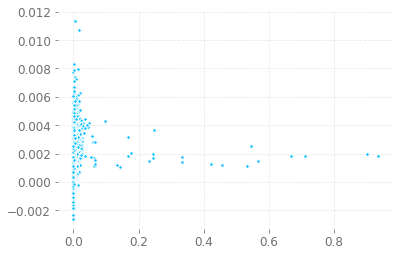

In [28]:
df_for_linearReg = easy_df.dropna()
X = df_for_linearReg[["time", "coord_dist_sum", "repeat_count_sum", "duration_sum", "d_time_avg"]]
y = df_for_linearReg.failtimes_norm
testSize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize)
 
# train the model
lm = LinearRegression()
lm.fit(X_train, y_train)
 
# return model coefficients
print("Coefficients for linear regression are",lm.coef_, "and the intercept is",lm.intercept_)
 
# plot
y_pred = lm.predict(X_test)
plt.plot(y_test, y_pred, ".")
 
print("mse for linear regression is", mean_squared_error(y_test, y_pred))
print("r^2 for linear regression is",r2_score(y_test, y_pred))
##correlation matrix, residual plot

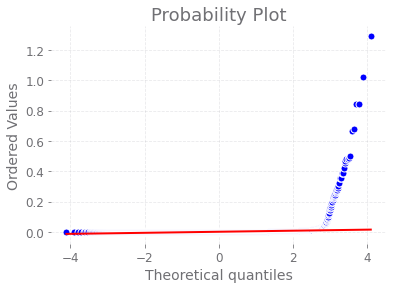

In [29]:
##qq plot
stats.probplot(y_train, dist="norm", plot=pylab)
pylab.show()

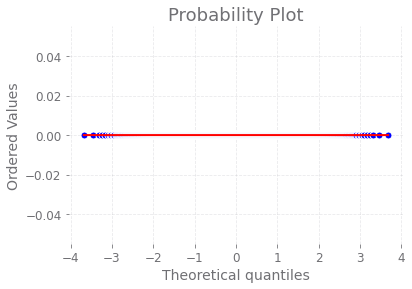

In [30]:
small = np.sort(df_for_linearReg.failtimes_norm)[4000:10000]
stats.probplot(small, dist="norm", plot=pylab)
pylab.show()

### 2. KNN Regression Model
We attempted to try a KNN Regression Model. However, after doing research into the topic, we found that KNN models work best with 2 predictors. Since our data has over 2 predictors, we decided that the KNN Regression Model was not the right choice for this problem.

### 3. XGBoost Random Forest Regression Model

In [31]:
df_for_XGBoost = partition_all_df
X = df_for_XGBoost[["coord_dist_sum_sum", "repeat_count_sum_sum", "duration_sum_sum", "d_time_avg_sum"]]
y = df_for_XGBoost.failtimes_norm_sum

In [32]:
y_pred_point2, y_test_point2, rmse_percent_point2 = Xgboost_est_pp_model().train_test_model(X, y, 0.2)

/home/ec2-user/.local/share/virtualenvs/dsu-mlpp-LeXi4iVD/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [33]:
y_pred_vs_real_df_point2 = pd.DataFrame({"y_pred": y_pred_point2, "y_real": y_test_point2})

<AxesSubplot:>

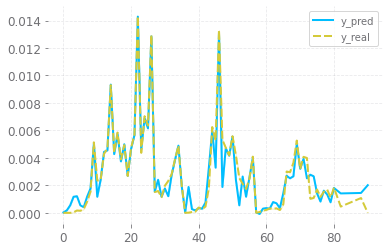

In [34]:
sns.lineplot(data = y_pred_vs_real_df_point2)